In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("advertising.csv", engine="python")  
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [17]:
df.shape

(200, 4)

In [18]:
def manual_correlation(x, y):
    return np.corrcoef(x, y)[0, 1]

print("📊 Manual Pearson Correlation with 'Sales':")
for feature in ['TV', 'Radio', 'Newspaper']:
    corr = manual_correlation(df[feature], df['Sales'])
    print(f"{feature} ↔ Sales: {corr:.4f}")


📊 Manual Pearson Correlation with 'Sales':
TV ↔ Sales: 0.9012
Radio ↔ Sales: 0.3496
Newspaper ↔ Sales: 0.1580


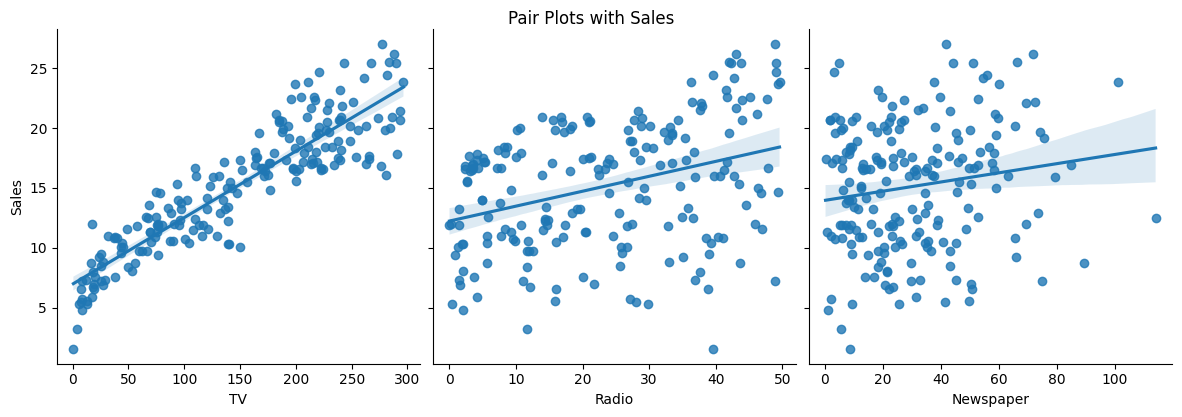

In [ ]:
# #pairplot
# sns.pairplot(df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', kind='reg', height=4)
# plt.suptitle("Pair Plots with Sales", y=1.02)
# plt.show()

# preprocessing

In [ ]:
X_raw = df[['TV', 'Radio', 'Newspaper']].values
y = df['Sales'].values.reshape(-1, 1) 
n_samples = X_raw.shape[0]

In [39]:

# ⚖️ Standardize features with protection against divide by zero
X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0)
X_std[X_std == 0] = 1  # Avoid division by zero

X_scaled = (X_raw - X_mean) / X_std
X = np.hstack((np.ones((n_samples, 1)), X_scaled))  # Add intercept

# modals


In [40]:
def batch_gradient_descent(X, y, alpha=0.01, epochs=500):
    n_samples = X.shape[0]
    w = np.zeros((X.shape[1], 1))
    loss_history = []

    for epoch in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        loss = (1 / (2 * n_samples)) * np.sum(error ** 2)
        loss_history.append(loss)

        gradient = (1 / n_samples) * (X.T @ error)
        w -= alpha * gradient

    return w, loss_history


In [41]:
def online_gradient_descent(X, y, alpha=0.01, epochs=500):
    n_samples = X.shape[0]
    w = np.zeros((X.shape[1], 1))
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_samples):
            xi = X[i].reshape(1, -1)
            yi = y[i].reshape(1, 1)
            pred = xi @ w
            error = pred - yi
            grad = xi.T @ error
            w -= alpha * grad
            total_loss += (error ** 2).item()
        loss_history.append(total_loss / n_samples)

    return w, loss_history


In [59]:
def MomentumBased_GD(X, y,b=0.9,lr=0.5, epochs=500):
    w = np.zeros((X.shape[1], 1))
    n=X.shape[0]
    v = np.zeros_like(w)    
    loss_history=[]

    for i in range(epochs):

        g=(X.T@((X@w)-y))/n
        v=b*v+lr*g
        w=w-v

        loss=0.5*np.mean(((X@w)-y)**2)
        loss_history.append(loss)
    return w,loss_history

In [ ]:
def NesterovAccelerated_GD(X, y,b=0.9,lr=0.5, epochs=500):
    w = np.zeros((X.shape[1], 1))
    n=X.shape[0]
    v = np.zeros_like(w)    
    loss_history=[]

    for i in range(epochs):

        g=(X.T@((X@(w-b*v))-y))/n
        v=b*v+lr*g
        w=w-v

        loss=0.5*np.mean(((X@w)-y)**2)
        loss_history.append(loss)
    return w,loss_history

# training

In [60]:
w_moment,loss_moment=MomentumBased_GD(X,y)

In [56]:
w_NAG,loss_NAG=NesterovAccelerated_GD(X,y)

In [71]:
w_batch, loss_batch = batch_gradient_descent(X, y)

In [70]:
w_online, loss_online = online_gradient_descent(X, y)

# comparition

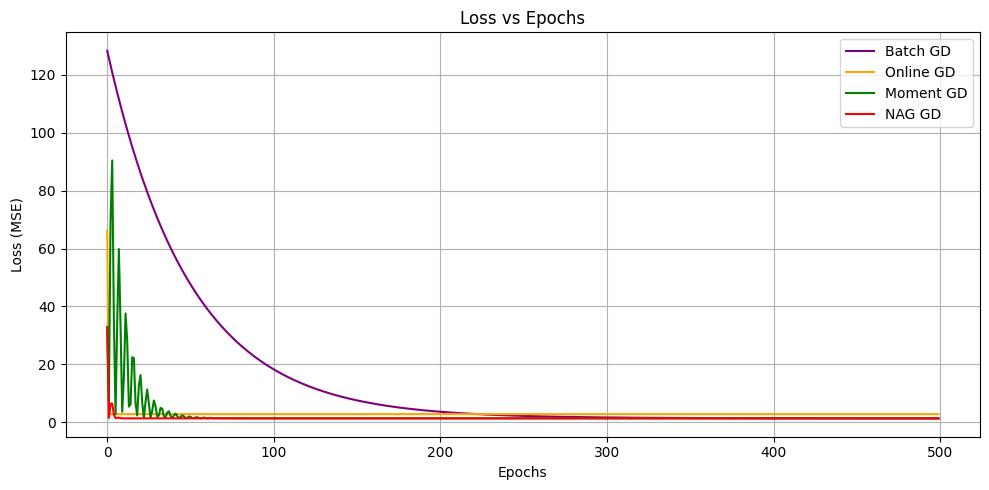

In [72]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(loss_batch)), y=loss_batch, label="Batch GD", color='purple')
sns.lineplot(x=range(len(loss_online)), y=loss_online, label="Online GD", color='orange')
sns.lineplot(x=range(len(loss_moment)), y=loss_moment, label="Moment GD", color='green')
sns.lineplot(x=range(len(loss_NAG)), y=loss_NAG, label="NAG GD", color='red')

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
w_NAG.shape

(4, 1)

# Prediction

In [ ]:
def plot_predictions(X, y, w, title):
    y_pred = X @ w
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y.flatten(), y=y_pred.flatten(), color='teal', alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return y_pred

y_pred_batch = plot_predictions(X, y, w_batch, "Actual vs Predicted (Batch GD)")
y_pred_online = plot_predictions(X, y, w_online, "Actual vs Predicted (Online GD)")
y_pred_moment = plot_predictions(X, y, w_moment, "Actual vs Predicted (MOment GD)")
y_pred_NAG = plot_predictions(X, y, w_NAG, "Actual vs Predicted (NAG GD)")

In [69]:
def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_res / ss_total)

print(f"R² Score (Batch GD): {r2_score(y, y_pred_batch):.4f}")
print(f"R² Score (Online GD): {r2_score(y, y_pred_online):.4f}")
print(f"R² Score (Moment GD): {r2_score(y, y_pred_moment):.4f}")
print(f"R² Score (NAG GD): {r2_score(y, y_pred_NAG):.4f}")


R² Score (Batch GD): 0.9022
R² Score (Online GD): 0.9022
R² Score (Moment GD): 0.9026
R² Score (NAG GD): 0.9026


In [68]:
    
print("\n📈 Final Parameters:")
print("Batch Gradient Descent:")
print(f"Intercept: {w_batch[0][0]:.4f}")
for i, name in enumerate(['TV', 'Radio', 'Newspaper']):
    print(f"{name}: {w_batch[i+1][0]:.4f}")

print("\nOnline Gradient Descent:")
print(f"Intercept: {w_online[0][0]:.4f}")
for i, name in enumerate(['TV', 'Radio', 'Newspaper']):
    print(f"{name}: {w_online[i+1][0]:.4f}")

    
print("Batch Gradient Descent:")
print(f"Intercept: {w_moment[0][0]:.4f}")
for i, name in enumerate(['TV', 'Radio', 'Newspaper']):
    print(f"{name}: {w_moment[i+1][0]:.4f}")

print("\nOnline Gradient Descent:")
print(f"Intercept: {w_NAG[0][0]:.4f}")
for i, name in enumerate(['TV', 'Radio', 'Newspaper']):
    print(f"{name}: {w_NAG[i+1][0]:.4f}")    



📈 Final Parameters:
Batch Gradient Descent:
Intercept: 15.0311
TV: 4.6319
Radio: 1.5565
Newspaper: 0.0417

Online Gradient Descent:
Intercept: 15.1290
TV: 4.6953
Radio: 1.6405
Newspaper: -0.0971
Batch Gradient Descent:
Intercept: 15.1305
TV: 4.6627
Radio: 1.5847
Newspaper: 0.0073

Online Gradient Descent:
Intercept: 15.1305
TV: 4.6627
Radio: 1.5847
Newspaper: 0.0073


In [ ]:
def predict_new(X_new, w, X_mean, X_std):
    
    X_new = np.array(X_new).reshape(1, -1)
    X_std_safe = np.where(X_std == 0, 1, X_std)
    X_new_scaled = (X_new - X_mean) / X_std_safe
    X_new_aug = np.hstack((np.ones((1, 1)), X_new_scaled))
    y_pred = X_new_aug @ w
    return y_pred[0][0]